<a href="https://colab.research.google.com/github/priyankachahal/AlertSystemWebDashboard/blob/master/features_ecg_project_svm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install -q https://github.com/neuropsychology/NeuroKit.py/zipball/master
!pip install joblib
%tensorflow_version 1.x

     / 85.0MB 163.7MB/s
     |████████████████████████████████| 6.6MB 2.5MB/s 
     |████████████████████████████████| 81kB 10.7MB/s 
TensorFlow 1.x selected.


In [3]:
pip install https://github.com/neuropsychology/neurokit/zipball/master

     - 137.5MB 154.0MB/s
  Created wheel for neurokit2: filename=neurokit2-0.0.27-py2.py3-none-any.whl size=829430 sha256=177e722112eb9ed0744dd26ebc071ebcf5bffa80680d0012b8b93bfcc5c89e9f
  Stored in directory: /tmp/pip-ephem-wheel-cache-nrawfdu2/wheels/96/b4/4a/5737e93a6740c234539e1fccf52cc0a868c42ae1c667dbefc6
Successfully built neurokit2


In [4]:
pip install py-ecg-detectors

     |████████████████████████████████| 563kB 3.9MB/s 
  Created wheel for gatspy: filename=gatspy-0.3-cp36-none-any.whl size=43806 sha256=ee5c955ca4dac3b3ded034facc6b1f417d3db3f2dcb937a2e22a7563b08deea2
  Stored in directory: /root/.cache/pip/wheels/4f/8f/fa/0d7b250ef21828ca373b21f6b3b6ef0f2a0e3560b69c91e55d
Successfully built gatspy


In [0]:
import os
import sys
import glob
import math
import pickle

import matplotlib.pyplot as plt
import neurokit as nk
import neurokit2 as nk2
import numpy as np
from numpy import where
import pandas as pd
import tensorflow as tf
import seaborn as sns
from sklearn.decomposition import PCA

from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

from sklearn.externals import joblib
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score


from scipy import signal
from scipy.signal import butter, sosfilt, sosfilt_zi, sosfiltfilt, lfilter, lfilter_zi, filtfilt, sosfreqz, resample
from ecgdetectors import Detectors, MWA, panPeakDetect

import warnings
warnings.simplefilter('ignore', DeprecationWarning)

In [0]:
# paths for different type of files
ecg_values_files_path = '/content/drive/My Drive/Final Project/dataset/ecg-bg/data/ECG'
data_frame_file_path = '/content/drive/My Drive/Final Project/dataset/ecg-bg/ecg_reading_data_frame.csv'
meta_data_file_path = '/content/drive/My Drive/Final Project/dataset/ecg-bg/data/meta.csv'
features_labelled_data_file_path = '/content/drive/My Drive/Final Project/dataset/ecg-bg/features-data-label.txt'

In [0]:
def extract_filename_from_path(path):
  return (os.path.split(path)[1])

In [0]:
def get_input_dataframe(use_data_frame_file = True):
  # read the labels from meta data and append them in the end
  meta_data_frame = pd.read_csv(meta_data_file_path, engine='python',skiprows = 1, names=['Id',	'Date',	'Time',	'Age',	'Gender',	'Height',	'Weight',	'Hr',	'G'])
  ecg_labels_dict = {}
  for index, row in meta_data_frame.iterrows():
    if (int(row["G"]) > 140):
      ecg_labels_dict[row["Id"]] = 1
    else:
      ecg_labels_dict[row["Id"]] = 0
      # ecg_labels_dict[row["Id"]] = int(row["G"])
  # read the ecg values either from pre-calculated file or from each file by file.
  ecg_values_data_frame = pd.DataFrame()
  if use_data_frame_file:
      ecg_values_data_frame = pd.read_csv(data_frame_file_path, engine='python')
  else:
    all_files = glob.glob(ecg_values_files_path + '/*.csv')
    li_df = []
    counter = 0
    for filename in all_files:
      df = pd.read_csv(filename, usecols=[1], engine='python')
      df = df.transpose();
      df.insert(0, 'fn', extract_filename_from_path(filename))
      li_df.append(df)
      counter = counter + 1
      if counter % 10 == 0:
        print(counter)
    ecg_values_data_frame = pd.concat(li_df, axis=0, ignore_index=True)
  label_serries_arr = []
  # iterate over file name column so that we can create a corresponding column for labels to be appended to ecg_values_data_frame
  for filename_col in ecg_values_data_frame[['fn']]:
    for index, x in np.ndenumerate(ecg_values_data_frame[filename_col].values):
      key = x.replace(".csv", "")
      label_serries_arr.append(ecg_labels_dict[key])
  label_serries = pd.Series(data=label_serries_arr)
  ecg_values_data_frame['labels'] = label_serries
  ecg_values_data_frame = ecg_values_data_frame.dropna(axis=1)
  return ecg_values_data_frame

In [0]:
ecg_values_data_frame_with_file_name = get_input_dataframe()
ecg_values_data_frame = ecg_values_data_frame_with_file_name.drop('fn', 1)
ecg_values = ecg_values_data_frame.values
# ecg_values_data_frame[:5]

In [21]:
ecg_values_data_frame.shape

(2238, 49968)

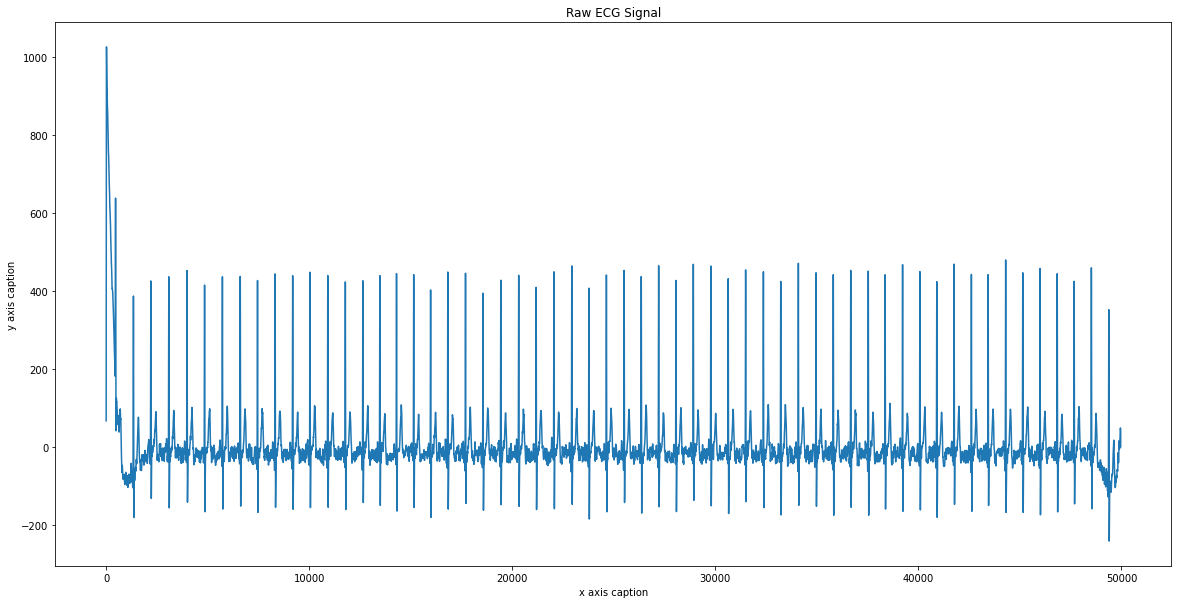

In [10]:
x = np.arange(0,len(ecg_values_data_frame.to_numpy()[1])) 
plt.figure(figsize=(20,10))
plt.title("Raw ECG Signal") 
plt.xlabel("x axis caption") 
plt.ylabel("y axis caption") 
plt.plot(x,ecg_values_data_frame.to_numpy()[1]) 
plt.show()

In [0]:
def butter_bandpass(lowcut, highcut, fs, order=4): #fs = sample frequency, order = Polynomial order of the signal
    nyq = 0.5 * fs  #Nyquist Frequency = minimum rate at which a finite bandwidth signal needs to be sampled to retain all of the information
    low = lowcut / nyq 
    high = highcut / nyq
    sos = butter(order, [low, high], analog=False, btype="band", output="sos")
    return sos

In [0]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
    sos = butter_bandpass(lowcut, highcut, fs, order=order)
    y = sosfilt(sos,data) 
    return y

In [0]:
ecg_values_data_frame_filtered = butter_bandpass_filter(ecg_values_data_frame,1,40,1000,4)

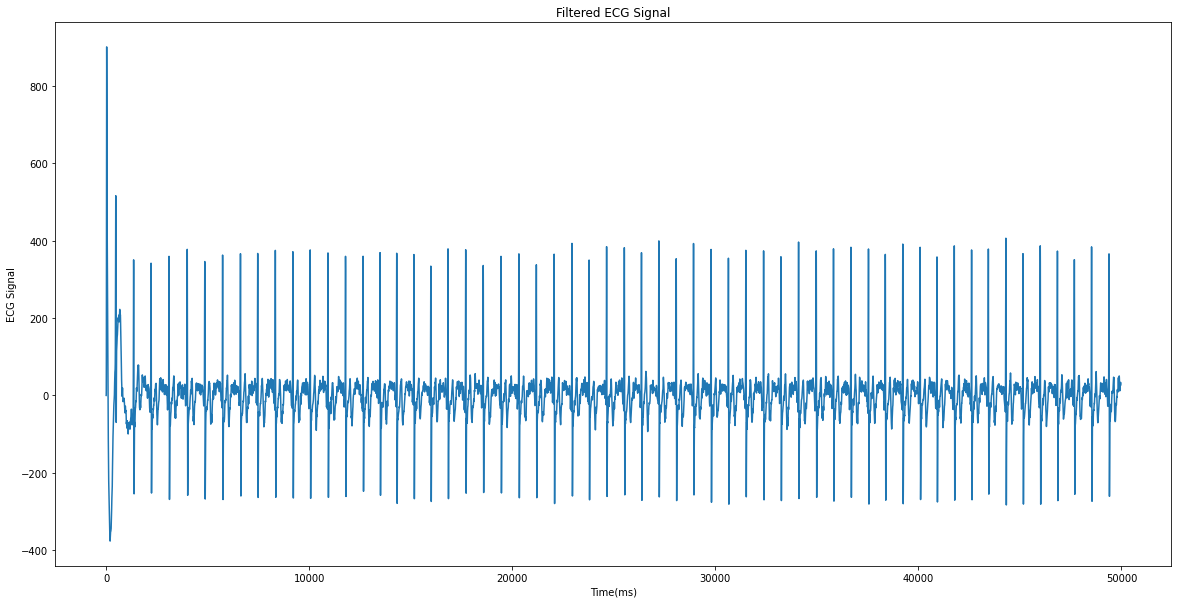

In [216]:
x = np.arange(0,len(ecg_values_data_frame_filtered[1])) 
plt.figure(figsize=(20,10))
plt.title("Filtered ECG Signal") 
plt.xlabel("Time(ms)") 
plt.ylabel("ECG Signal") 
plt.plot(x,ecg_values_data_frame_filtered[1]) 
plt.show()

In [0]:
# ecg_values_data_frame_filtered[:5]

In [0]:
def getCleanECG(data):
  ecg_values_data_frame_cleaned = []
  for ecg_index in data:
    ecg_values_data_frame_cleaned.append(nk2.ecg_clean(ecg_index.flatten(), sampling_rate=1000))
  return ecg_values_data_frame_cleaned

In [0]:
ecg_values_data_frame_cleaned = getCleanECG(ecg_values_data_frame_filtered)

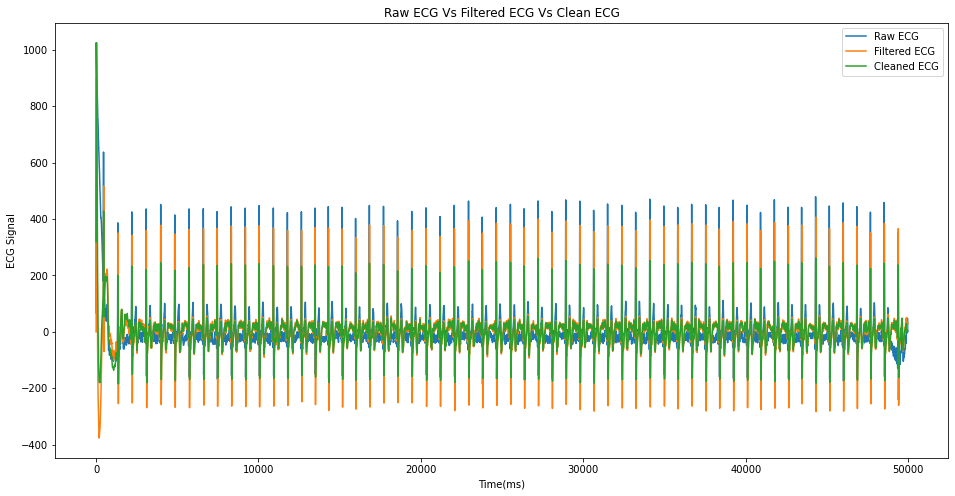

In [244]:
x = np.arange(0,len(ecg_values_data_frame_cleaned[1])) 
plt.figure(figsize=(16,8))
plt.title("Raw ECG Vs Filtered ECG Vs Clean ECG") 
plt.xlabel("Time(ms)") 
plt.ylabel("ECG Signal") 
plt.plot(x,ecg_values_data_frame.to_numpy()[1],label='Raw ECG') 
plt.plot(x,ecg_values_data_frame_filtered[1],label='Filtered ECG')
plt.plot(x,ecg_values_data_frame_cleaned[1],label='Cleaned ECG')
plt.legend(loc="upper right") 
plt.show()

In [0]:
# ecg_values_data_frame_cleaned[:5]

In [0]:
def getRPeaks(ecg):
  rPeaks = []
  index_counter = 0;
  for ecg_index in ecg:
    rPeaks.append(nk2.ecg_findpeaks(ecg_index.flatten(), sampling_rate=1000,method="pantompkins1985"))
    index_counter += 1
    if(index_counter%100==0):
      print(index_counter)
  return rPeaks

In [0]:
rPeaks = getRPeaks(ecg_values_data_frame_cleaned)

In [0]:
# rPeaks[1]['ECG_R_Peaks']

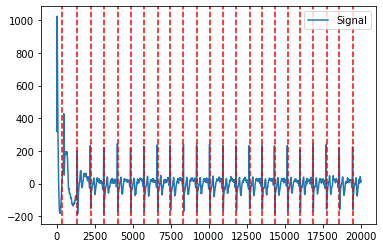

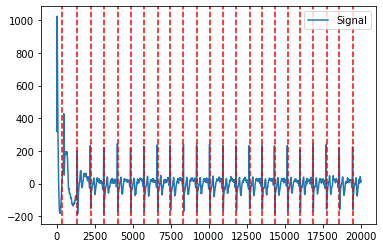

In [47]:
nk2.events_plot(rPeaks[1]["ECG_R_Peaks"][:23],ecg_values_data_frame_cleaned[1][:20000])

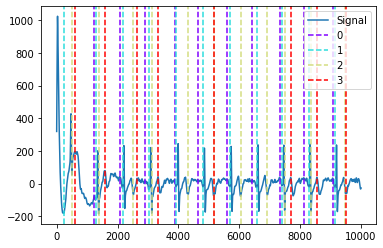

In [58]:
plot = nk2.events_plot([
waves_peak['ECG_P_Peaks'][:11],
waves_peak['ECG_Q_Peaks'][:11],
waves_peak['ECG_S_Peaks'][:11],
waves_peak['ECG_T_Peaks'][:11]],ecg_values_data_frame_cleaned[1][:10000])

In [0]:
def calculate_euclidean_distance(Ax, Ay, Bx, By):
  return math.sqrt((Bx - Ax)**2 + (By - Ay)**2);

In [0]:
def calculate_slope(Ax, Ay, Bx, By):
  return (By - Ay)/(Bx - Ax)

In [0]:
def get_index_magnitude(indices, magnitude, fiducial_point_set):
  # print(sorted(fiducial_point_set), indices, magnitude)
  index_counter = 0;
  for index in indices:
    if index in fiducial_point_set:
      #print(index, magnitude)
      return index, magnitude[index_counter]
    index_counter += 1
  return 0,0

In [0]:
def get_features_from_processed_ecg(processed_ecg):
  # get all 18 features for each cycle/segment
  # rpeaks_inds = list(processed_ecg['ECG']['R_Peaks'])
  ECG_Filtered = list(processed_ecg['df']['ECG_Filtered'])
  P_Waves = set(list(processed_ecg['ECG']['P_Waves']))
  Q_Waves_Ends = set(list(processed_ecg['ECG']['Q_Waves']))
  Q_Waves_Starts = set(list(processed_ecg['ECG']['Q_Waves_Onsets']))
  S_Waves = set(list(processed_ecg['ECG']['S_Waves']))
  T_Waves_Mid = set(list(processed_ecg['ECG']['T_Waves']))
  T_Waves_Ends = set(list(processed_ecg['ECG']['T_Waves_Ends']))
  T_Waves_Starts = set(list(processed_ecg['ECG']['T_Waves_Onsets']))

  feature_data_vals = []
  len_of_ECG = len(ECG_Filtered) # ECG data sampled at 1000Hz.
  left_algn_ecg = 130            # 150 ms left of Rpeak
  right_algn_ecg = 270           # 250 ms right of rpeak
  sample_step = 1
  seg_number = 0
  for each_rpeak_ind in rPeaks :
      seg_number += 1
      if seg_number == 1:
        continue;
      temp_data = []
      temp_inds = []
      temp_dict = {}
      for all_data in range((each_rpeak_ind - left_algn_ecg), (each_rpeak_ind + right_algn_ecg), sample_step) :
          temp_inds.append(all_data)
          temp_data.append(ECG_Filtered[all_data])
      #print('R_Peak', each_rpeak_ind)
      P_x, P_y = get_index_magnitude(temp_inds, temp_data, P_Waves)
      #print('P_Waves', P_x, P_y)
      Q_x, Q_y = get_index_magnitude(temp_inds, temp_data, Q_Waves_Ends)
      #print('Q_Waves_Ends', Q_x, Q_y)
      S_x, S_y = get_index_magnitude(temp_inds, temp_data, S_Waves)
      #print('S_Waves', S_x, S_y)
      T_x, T_y = get_index_magnitude(temp_inds, temp_data, T_Waves_Mid)
      #print('T_Waves_Mid', T_x, T_y)
      R_x, R_y = each_rpeak_ind, ECG_Filtered[each_rpeak_ind]
      #print('R_Waves', R_x, R_y)
      temp_dict['inds'] = temp_inds
      temp_dict['sig'] = temp_data
      temp_dict['rpeak'] = ECG_Filtered[each_rpeak_ind]
      temp_dict['rpeak_ind'] = each_rpeak_ind
      temp_dict['seg_number'] = seg_number
      if (P_x == 0 or P_y == 0 or Q_x == 0 or Q_y == 0 or S_x == 0 or S_y == 0 or T_x == 0 or T_y == 0 or R_x == 0 or R_y == 0):
        #ignoring ecg cycle which are more than 400 ms
        continue
      else:
        # print('P, Q, R, S, T ', P_x, P_y, Q_x, Q_y, S_x, S_y, T_x, T_y, R_x, R_y)
        # calculate features
        PQ_dist = calculate_euclidean_distance(P_x, P_y, Q_x, Q_y)
        PR_dist = calculate_euclidean_distance(P_x, P_y, R_x, R_y)
        PS_dist = calculate_euclidean_distance(P_x, P_y, S_x, S_y)
        PT_dist = calculate_euclidean_distance(P_x, P_y, T_x, T_y)
        QR_dist = calculate_euclidean_distance(Q_x, Q_y, R_x, R_y)
        QS_dist = calculate_euclidean_distance(Q_x, Q_y, S_x, S_y)
        QT_dist = calculate_euclidean_distance(Q_x, Q_y, T_x, T_y)
        RS_dist = calculate_euclidean_distance(R_x, R_y, S_x, S_y)
        RT_dist = calculate_euclidean_distance(R_x, R_y, T_x, T_y)

        PQ_slope = calculate_slope(P_x, P_y, Q_x, Q_y)
        PR_slope = calculate_slope(P_x, P_y, R_x, R_y)
        PS_slope = calculate_slope(P_x, P_y, S_x, S_y)
        PT_slope = calculate_slope(P_x, P_y, T_x, T_y)
        QR_slope = calculate_slope(Q_x, Q_y, R_x, R_y)
        QS_slope = calculate_slope(Q_x, Q_y, S_x, S_y)
        QT_slope = calculate_slope(Q_x, Q_y, T_x, T_y)
        RS_slope = calculate_slope(R_x, R_y, S_x, S_y)
        RT_slope = calculate_slope(R_x, R_y, T_x, T_y)        

        feature_data_vals.append(PQ_dist)
        feature_data_vals.append(PR_dist)
        feature_data_vals.append(PS_dist)
        feature_data_vals.append(PT_dist)
        feature_data_vals.append(QR_dist)
        feature_data_vals.append(QS_dist)
        feature_data_vals.append(QT_dist)
        feature_data_vals.append(RS_dist)
        feature_data_vals.append(RT_dist)
        feature_data_vals.append(PQ_slope)
        feature_data_vals.append(PR_slope)
        feature_data_vals.append(PS_slope)
        feature_data_vals.append(PT_slope)
        feature_data_vals.append(QR_slope)
        feature_data_vals.append(QS_slope)
        feature_data_vals.append(QT_slope)
        feature_data_vals.append(RS_slope)
        feature_data_vals.append(RT_slope)

  return feature_data_vals

In [0]:
def extract_features_from_dataframe(data_frame):
  features_list_labelled = []
  counter = 0
  for index, row in data_frame.iterrows():
    np_temp = row.dropna().to_numpy()
    # processed_ecg = nk.ecg_process(np_temp,sampling_rate=1000,filter_type='IIR',filter_band='bandpass',filter_frequency=[1, 40],segmenter='hamilton',quality_model='default') 
    waves = nk.ecg_delineate(np_temp, rpeaks, sampling_rate=1000)
    features_labeled = get_features_from_processed_ecg(waves)
    features_labeled.append(int(row['labels']))
    features_list_labelled.append(features_labeled)
    counter += 1
    if counter % 100 == 0:
      print(counter)
  return features_list_labelled

In [0]:
features_labelled_list = extract_features_from_dataframe(ecg_values_data_frame)

In [0]:
with open(features_labelled_data_file_path, "wb") as fp:
  pickle.dump(features_labelled_list, fp)

In [0]:
with open(features_labelled_data_file_path, "rb") as fp:   # Unpickling
  features_labelled_list = pickle.load(fp)

In [0]:
# features_labelled_list[1]

In [0]:
def sample_training_dataset(input_values, percentage = 0.7):
  freqmap = np.array(np.unique(input_values[:, [input_values.shape[1] - 1]].astype(int), return_counts=True)).T
  # print (freqmap)
  freqmap[:,1] = freqmap[:,1].astype(float) * percentage
  # stores the required freq of each label
  labelCountDict = {};
  for label, freq in freqmap:
    labelCountDict[label] = float(freq)
  # print(labelCountDict)
  train_arr, test_arr = [], []
  # go through each row of input array after removing NaN
  for row in input_values:
    label_column_index = row[input_values.shape[1] - 1]
    # if we still have required freq of label, we add to train dataset or add to test dataset
    if labelCountDict[label_column_index] > 0:
      train_arr.append(row)
      labelCountDict[label_column_index] = labelCountDict[label_column_index] - 1
    else:
      test_arr.append(row)
  return np.array(train_arr), np.array(test_arr)

In [0]:
def getNumpyNDArray(rpeak_labelled):
  features = []
  labels = []
  for record in rpeak_labelled:
    labels.append(record[-1])
    record = record[:-1]
    features.append(record)
  features_df = pd.DataFrame(features)
  features_numpy_array = np.asarray(features_df)
  features_numpy_array = np.nan_to_num(features_numpy_array)

  labels_df = pd.DataFrame(labels)
  labels_numpy_array = np.asarray(labels_df)

  return np.concatenate((features_numpy_array, labels_numpy_array), axis=1)

In [0]:
A = getNumpyNDArray(features_labelled_list)
train,test = sample_training_dataset(A, 0.9)

In [0]:
train_normal = train[train[:, -1]==0]
train_outliers = train[train[:, -1]==1]

test = np.concatenate((test, train_outliers))

y_test = test[:, -1]
test = test[:,:len(A[1])]
train_normal = train_normal[:,:len(A[1])] 

scaler = StandardScaler()
train_x = scaler.fit_transform(train_normal)
test_x = scaler.fit_transform(test)

In [0]:
outlier_prop = len(train_outliers) / len(train_normal) 

**One class svm with linear kernel replacing nan to 0**

False Positive Rate : [0.9112426 0.0821256]
False Negative Rate : [0.0821256 0.9112426]
Accuracy : [0.54521277 0.54521277]
              precision    recall  f1-score   support

         0.0       0.55      0.92      0.69       207
         1.0       0.47      0.09      0.15       169

    accuracy                           0.55       376
   macro avg       0.51      0.50      0.42       376
weighted avg       0.51      0.55      0.45       376



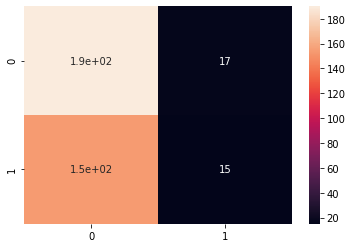

In [71]:
svm_linear = OneClassSVM(kernel='linear',nu=outlier_prop, gamma=0.00000001) #outlier_prop = 0.081
svm_linear.fit(train_normal)
y_predict_ocv_linear = svm_linear.predict(test)
y_predict_ocv_linear=np.where(y_predict_ocv_linear==1, 0, y_predict_ocv_linear)
y_predict_ocv_linear=np.where(y_predict_ocv_linear==-1, 1, y_predict_ocv_linear)

cnf_matrix = confusion_matrix(y_test, y_predict_ocv_linear)
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)

# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
#accuracy
Accuracy = (TP+TN)/(TP+TN+FP+FN)

print('False Positive Rate :', FPR)
print('False Negative Rate :',FNR)
print('Accuracy :', Accuracy)

print(classification_report(y_test,y_predict_ocv_linear))

sns.heatmap(cnf_matrix, annot= True)

**one class svm with poly kernel**

False Positive Rate : [0.90532544 0.0821256 ]
False Negative Rate : [0.0821256  0.90532544]
Accuracy : [0.54787234 0.54787234]
              precision    recall  f1-score   support

         0.0       0.55      0.92      0.69       207
         1.0       0.48      0.09      0.16       169

    accuracy                           0.55       376
   macro avg       0.52      0.51      0.42       376
weighted avg       0.52      0.55      0.45       376



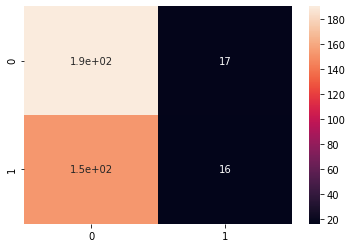

In [72]:
svm_poly = OneClassSVM(kernel='poly',degree=2,nu=outlier_prop, gamma=0.00000001) #degree=2 : 52% , gamma greater than this value doesn't have any impact but reducing the value decreases the accuracy 
svm_poly.fit(train_normal)
y_predict_ocs_poly = svm_poly.predict(test)
y_predict_ocs_poly=np.where(y_predict_ocs_poly==1, 0, y_predict_ocs_poly)
y_predict_ocs_poly=np.where(y_predict_ocs_poly==-1, 1, y_predict_ocs_poly)

cnf_matrix = confusion_matrix(y_test, y_predict_ocs_poly)
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)

# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
#accuracy
Accuracy = (TP+TN)/(TP+TN+FP+FN)

print('False Positive Rate :', FPR)
print('False Negative Rate :',FNR)
print('Accuracy :', Accuracy)

print(classification_report(y_test,y_predict_ocs_poly))

sns.heatmap(cnf_matrix, annot= True)

**one class svm with rbf kernel**

[[199   8]
 [142  27]]
False Positive Rate : [0.84023669 0.03864734]
False Negative Rate : [0.03864734 0.84023669]
Accuracy : [0.60106383 0.60106383]
              precision    recall  f1-score   support

         0.0       0.58      0.96      0.73       207
         1.0       0.77      0.16      0.26       169

    accuracy                           0.60       376
   macro avg       0.68      0.56      0.50       376
weighted avg       0.67      0.60      0.52       376

None


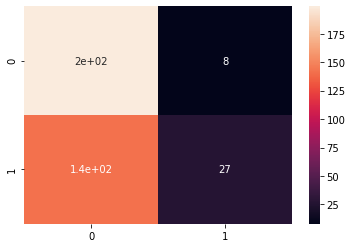

In [73]:
svm_rbf = OneClassSVM(kernel='rbf',nu=outlier_prop, gamma=0.00000001) # > or < gamma value decreases accuracy
svm_rbf.fit(train_normal)
y_predict_rbf = svm_rbf.predict(test)
y_predict_rbf=np.where(y_predict_rbf==1, 0, y_predict_rbf)
y_predict_rbf=np.where(y_predict_rbf==-1, 1, y_predict_rbf)

cnf_matrix = confusion_matrix(y_test, y_predict_rbf)
print(cnf_matrix)
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)

# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
#accuracy
Accuracy = (TP+TN)/(TP+TN+FP+FN)

print('False Positive Rate :', FPR)
print('False Negative Rate :',FNR)
print('Accuracy :', Accuracy)

print(print(classification_report(y_test,y_predict_rbf)))

sns.heatmap(cnf_matrix, annot= True)

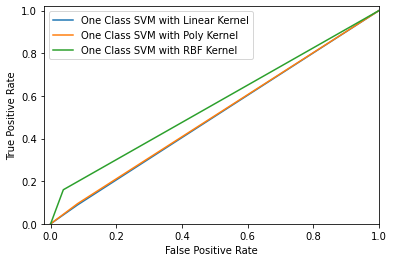

In [79]:
fpr_ocs_linear, tpr_ocs_linear,_ = roc_curve(y_test, y_predict_ocv_linear)
fpr_ocs_poly, tpr_ocs_poly,_ = roc_curve(y_test, y_predict_ocs_poly)
fpr_rbf, tpr_rbf,_ = roc_curve(y_test,y_predict_rbf)

plt.plot(fpr_ocs_linear, tpr_ocs_linear, label='One Class SVM with Linear Kernel')

plt.plot(fpr_ocs_poly, tpr_ocs_poly, label='One Class SVM with Poly Kernel')

plt.plot(fpr_rbf, tpr_rbf, label='One Class SVM with RBF Kernel')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([-0.02, 1])
plt.ylim([0, 1.02])
plt.legend(loc="upper left")

In [82]:
print("Linear:",roc_auc_score(y_test, y_predict_ocv_linear))
print("Poly:",roc_auc_score(y_test, y_predict_ocs_poly))
print("RBF:",roc_auc_score(y_test,y_predict_rbf))

Linear: 0.5033158962924849
Poly: 0.5062744761741417
RBF: 0.5605579853071492


 **Logistic Regression**

In [0]:
from sklearn.linear_model import LogisticRegression
A = getNumpyNDArray(features_labelled_list)

train,test = sample_training_dataset(A, 0.8)
train = np.nan_to_num(train)
test = np.nan_to_num(test)
train_x = train[:,:len(A[1])]
train_y = train[:,-1]
test_x = test[:,:len(A[1])]
test_y = test[:,-1]

scaler = StandardScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.fit_transform(test_x)

pca = PCA(n_components=10,random_state=42)
train_x = pca.fit_transform(train_x)
test_x = pca.fit_transform(test_x)

sm = SMOTE(sampling_strategy='not majority', random_state=42)
train_x, train_y = sm.fit_resample(train_x, train_y)

clf = LogisticRegression(penalty='l2',C=3,random_state=42) #regularization C = 4
clf.fit(train_x,train_y)
y_predict_lgr = clf.predict(test_x)

[[305 109]
 [ 22  12]]
False Positive Rate : [0.64705882 0.26328502]
False Negative Rate : [0.26328502 0.64705882]
Accuracy : [0.70758929 0.70758929]
              precision    recall  f1-score   support

         0.0       0.93      0.74      0.82       414
         1.0       0.10      0.35      0.15        34

    accuracy                           0.71       448
   macro avg       0.52      0.54      0.49       448
weighted avg       0.87      0.71      0.77       448



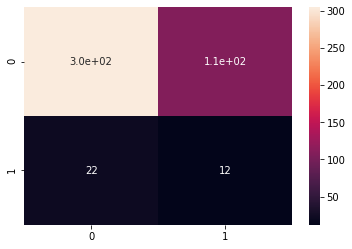

In [84]:
cnf_matrix = confusion_matrix(test_y, y_predict_lgr)
print(cnf_matrix)
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)

# Fall out or false positive rate
FPR = FP/(FP+TN)

# False negative rate
FNR = FN/(TP+FN)
#accuracy
Accuracy = (TP+TN)/(TP+TN+FP+FN)

print('False Positive Rate :', FPR)
print('False Negative Rate :',FNR)
print('Accuracy :', Accuracy)

print(classification_report(test_y,y_predict_lgr))

sns.heatmap(cnf_matrix, annot= True)

**Linear SVM**

In [0]:
from sklearn import svm
A = getNumpyNDArray(features_labelled_list)

train,test = sample_training_dataset(A, 0.8)
train = np.nan_to_num(train)
test = np.nan_to_num(test)
train_x = train[:,:len(A[1])]
train_y = train[:,-1]
test_x = test[:,:len(A[1])]
test_y = test[:,-1]

scaler = StandardScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.fit_transform(test_x)

pca = PCA(n_components=10,random_state=42)
train_x = pca.fit_transform(train_x)
test_x = pca.fit_transform(test_x)

sm = SMOTE(sampling_strategy='not majority', random_state=42)
train_x, train_y = sm.fit_resample(train_x, train_y)

SVM = svm.LinearSVC(penalty='l2',C=4,dual=False,random_state=42,multi_class='ovr')
SVM.fit(train_x, train_y)

y_predict_svm = SVM.predict(test_x)

[[308 106]
 [ 22  12]]
False Positive Rate : [0.64705882 0.25603865]
False Negative Rate : [0.25603865 0.64705882]
Accuracy : [0.71428571 0.71428571]
              precision    recall  f1-score   support

         0.0       0.93      0.74      0.83       414
         1.0       0.10      0.35      0.16        34

    accuracy                           0.71       448
   macro avg       0.52      0.55      0.49       448
weighted avg       0.87      0.71      0.78       448



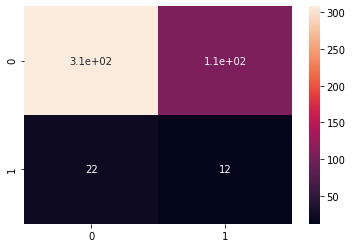

In [87]:
cnf_matrix = confusion_matrix(test_y, y_predict_svm)
print(cnf_matrix)
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)

# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
#accuracy
Accuracy = (TP+TN)/(TP+TN+FP+FN)

print('False Positive Rate :', FPR)
print('False Negative Rate :',FNR)
print('Accuracy :', Accuracy)

print(classification_report(test_y,y_predict_svm))

sns.heatmap(cnf_matrix, annot= True)

**Random Forest**

In [0]:
from sklearn.ensemble import RandomForestClassifier
A = getNumpyNDArray(features_labelled_list)

train,test = sample_training_dataset(A, 0.8)
train = np.nan_to_num(train)
test = np.nan_to_num(test)
train_x = train[:,:len(A[1])]
train_y = train[:,-1]
test_x = test[:,:len(A[1])]
test_y = test[:,-1]

sm = SMOTE(sampling_strategy='not majority', random_state=42)
train_x, train_y = sm.fit_resample(train_x, train_y)

scaler = StandardScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.fit_transform(test_x)

pca = PCA(n_components=15,random_state=42) #after n_components> or <15 accuracy drops
train_x = pca.fit_transform(train_x)
test_x = pca.fit_transform(test_x)

RF = RandomForestClassifier(n_estimators=200, max_depth=7, random_state=42) #depth =10 , 29,5 ,depth=20 class 1 is performing poorly 34,0 n_estimators<140 accuracy drops
RF.fit(train_x, train_y)

y_predict_RF = RF.predict(test_x)

[[360  54]
 [ 28   6]]
False Positive Rate : [0.82352941 0.13043478]
False Negative Rate : [0.13043478 0.82352941]
Accuracy : [0.81696429 0.81696429]
              precision    recall  f1-score   support

         0.0       0.93      0.87      0.90       414
         1.0       0.10      0.18      0.13        34

    accuracy                           0.82       448
   macro avg       0.51      0.52      0.51       448
weighted avg       0.87      0.82      0.84       448



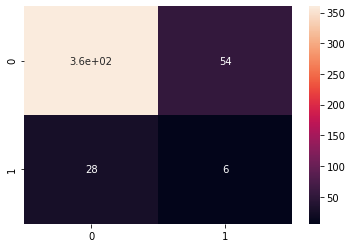

In [89]:
cnf_matrix = confusion_matrix(test_y, y_predict_RF)
print(cnf_matrix)
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)

# Fall out or false positive rate
FPR = FP/(FP+TN)
#True positive rate
TPR = TP/(TP+FN)
# False negative rate
FNR = FN/(TP+FN)
#accuracy
Accuracy = (TP+TN)/(TP+TN+FP+FN)

print('False Positive Rate :', FPR)
print('False Negative Rate :',FNR)
print('Accuracy :', Accuracy)

print(classification_report(test_y,y_predict_RF))

sns.heatmap(cnf_matrix, annot= True)

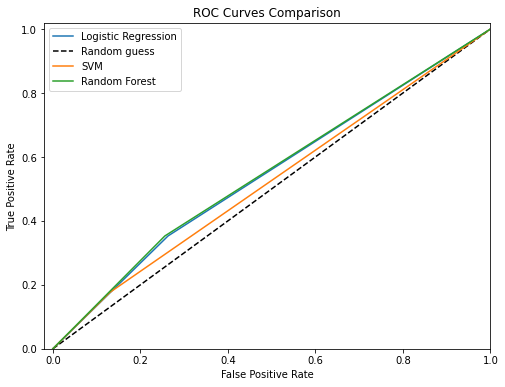

In [222]:
#ROC Curve
fpr_lgr, tpr_lgr, thresholds_lgr = roc_curve(test_y, y_predict_lgr)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(test_y, y_predict_RF)
fpr_svm, tpr_svm, thresholds_svm = roc_curve(test_y, y_predict_svm)

#Create plot
plt.figure(figsize=(8,6))
plt.title('ROC Curves Comparison')
plt.plot(fpr_lgr, tpr_lgr, label='Logistic Regression')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([-0.02, 1])
plt.ylim([0, 1.02])
plt.legend(loc="upper left")

plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.legend(loc="upper left")

plt.plot(fpr_svm, tpr_svm, label='SVM')
plt.legend(loc="upper left")

In [90]:
print("Linear:",roc_auc_score(test_y, y_predict_lgr))
print("Poly:",roc_auc_score(test_y, y_predict_RF))
print("RBF:",roc_auc_score(test_y, y_predict_svm))

Linear: 0.5448280761579994
Poly: 0.5230179028132993
RBF: 0.5484512645637966
